# Shapley Value Approximation

## Data Acquisition 

In [1]:
import numpy as np
from pydvl.utils import Dataset
import sklearn as sk
from pydvl.utils import Dataset, Utility
from sklearn import *
from pydvl.reporting.plots import plot_shapley
from pydvl.utils.dataset import GroupedDataset
from pydvl.value import *
import matplotlib.pyplot as plt

dataset = Dataset.from_sklearn(datasets.load_iris())
model = svm.SVC()
utility = Utility(model, dataset)


c:\Users\666\anaconda3\envs\python\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Group Testing

In [8]:
len(utility.data.x_train)


120

## Compressive Permutation

In [13]:
import numpy as np
import cvxpy as cp

def compressive_permutation_sampling(utility, M, T):
    """
    压缩感知置换采样计算Shapley Value.
    
    参数：
    D - 训练集，数据格式为 [ (x_i, y_i), ... ]
    M - 伯努利矩阵A的行数，压缩感知测量数
    T - 随机置换次数
    utility - 可调用对象，负责对训练数据子集重新训练并计算效用
    
    返回：
    训练集中每个数据点的Shapley Value估计
    """
    N = len(utility.data.x_train)  # 数据点个数
    
    # Step 1: 生成伯努利矩阵A
    A = np.random.choice([-1/np.sqrt(M), 1/np.sqrt(M)], size=(M, N))
    
    # Step 2: 初始化y的估计
    y_hat = np.zeros((M, T))
    
    # Step 3: 进行T次随机置换并计算y
    for t in range(T):
        # 生成随机置换
        permutation = np.random.permutation(N)
        
        # 计算每个数据点i的边际贡献phi
        phi_t = np.zeros(N)
        subset = set()
        for i in permutation:
            U_with_i = utility(permutation[:i+1])  # 加入i后的效用
            U_without_i = utility(permutation[:i])     # 未加入i时的效用
            phi_t[i] = U_with_i - U_without_i
            subset.add(i)
        
        # 对每个m，计算y_hat[m, t]
        for m in range(M):
            y_hat[m, t] = np.dot(A[m, :], phi_t)
    
    # Step 4: 对y求均值
    y_bar = np.mean(y_hat, axis=1)
    
    # Step 5: 初步估计每个点的Shapley Value
    U_D = utility(permutation)  # 整个数据集的效用
    s_bar = U_D / N
    
    # Step 6: 使用cvxpy进行压缩感知L1重建 Shapley Value
    delta_s = cp.Variable(N)  # 定义变量 delta_s
    epsilon = 1e-6  # 允许的误差范围
    
    # 目标：最小化 L1 范数 ||Δs||_1
    objective = cp.Minimize(cp.norm1(delta_s))
    
    # 约束：||A(s_bar + Δs) - y_bar||_2 <= epsilon
    constraints = [cp.norm2(A @ (s_bar + delta_s) - y_bar) <= epsilon]
    
    # 定义并求解优化问题
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Step 7: 检查是否求解成功
    if problem.status in ["infeasible", "unbounded"]:
        print("优化失败！返回初始估计。")
        delta_s_value = np.zeros(N)
    else:
        delta_s_value = delta_s.value

    # 最终Shapley Value估计
    s_hat = s_bar + delta_s_value
    return s_hat




# 参数设置
M = 50  # 压缩感知测量数
T = 100  # 随机置换次数

# 计算Shapley Value
shapley_values = compressive_permutation_sampling(utility, M, T)
print("Shapley Values:", shapley_values)


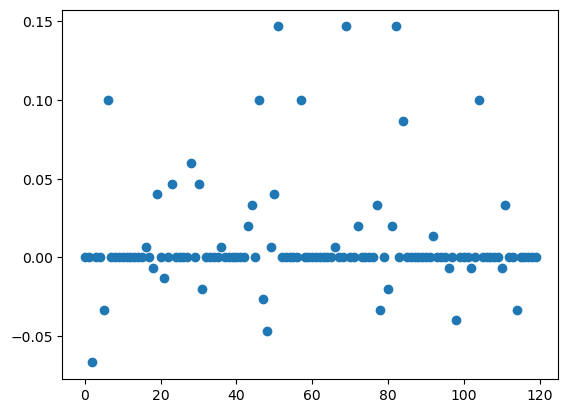

In [12]:
plt.scatter(range(120),shapley_values)

## Truncated Monte Carlo Approximation

In [3]:
values = compute_shapley_values(
    utility,
    mode = ShapleyMode.TruncatedMontecarlo,
    # Stop if the standard error is below 1% of the range of the values (which is ~2),
    # or if the number of updates exceeds 1000
    done=AbsoluteStandardError(threshold=0.2, fraction=0.9) | MaxUpdates(1000),
    truncation=RelativeTruncation(utility, rtol=0.01),
    n_jobs=-1,
)
#values.sort(key="value")
df = values.to_dataframe(column="data_value", use_names=True)

c:\Users\666\anaconda3\envs\python\lib\site-packages\pydvl\parallel\backends\joblib.py:87: UserWarning: Cancellation of futures is not supported by the joblib backend
  warnings.warn(


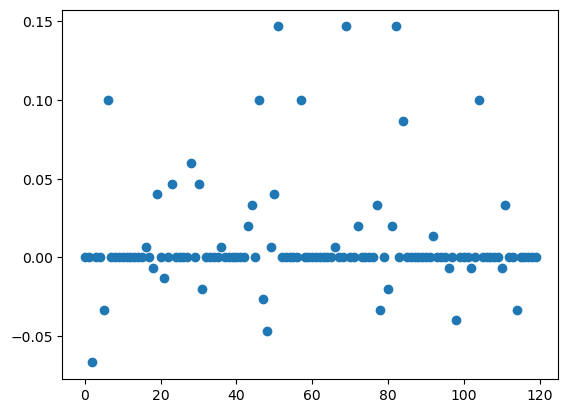

In [4]:
plt.scatter(range(120),df.data_value)

## Gradient Shapley Value

## Beta Shapley Value

In [5]:
ValuationResult = compute_beta_shapley_semivalues(
    u=utility,
    alpha=1,
    beta=1,
    done=AbsoluteStandardError(threshold=0.2, fraction=0.9) | MaxUpdates(1000),
    sampler_t=PermutationSampler,
    batch_size=128,
    n_jobs=1
)

PermutationSampler requires caching to be enabled or computation will be doubled wrt. a 'direct' implementation of permutation MC
c:\Users\666\anaconda3\envs\python\lib\site-packages\pydvl\parallel\backends\joblib.py:87: UserWarning: Cancellation of futures is not supported by the joblib backend
  warnings.warn(
